In [1]:
# %load scripts/nbpreamble.py
if not 'RUN_NAME' in locals():
    RUN_NAME = 'unknown'

import sys
import os
import shutil
import glob
import numpy as np
import warnings
import subprocess
import matplotlib
import matplotlib.pyplot as pl
from   matplotlib.patches import Circle, Polygon, RegularPolygon
%matplotlib inline

from desitarget.cuts import select_targets, qso_selection_options

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", module='desitarget')
    # Tries to set mpl backend
    from desitarget.QA import _parse_tcnames

from desiutil.log import get_logger

from importlib import reload

add_sys_path = list()
add_sys_path.append(os.path.join(os.getcwd(),'py'))

WITH_SPHERICAL_GEOMETRY = True
if WITH_SPHERICAL_GEOMETRY:
    add_sys_path.append(os.path.join(os.environ['HOME'],
                                 'software/modules/spherical_geometry/master/lib/python3.6/site-packages/spherical_geometry-1.2.5-py3.6-linux-x86_64.egg/'))

for _ in add_sys_path:
    if _ not in sys.path:
        sys.path.append(_)
                    
from apcsv.astropy_backports import *

if WITH_SPHERICAL_GEOMETRY:
    import spherical_geometry
    from spherical_geometry import polygon as spoly

import astropy
import astropy.units as u
import astropy.coordinates as coord
import regions
from   astropy.io import fits
from   astropy.table import Table, Column

import desiutil
import desiutil.plots
import desimodel
import desimodel.focalplane
import desitarget

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning, module="matplotlib")
    # Tries to set mpl backend
    import desitarget
import desitarget.io as io
import desitarget.mtl

import desitarget.targetmask
from   desitarget.targetmask import desi_mask, bgs_mask, mws_mask, obsmask, obsconditions

import fitsio

# SV planning object classes
import apcsv.plan
reload(apcsv.plan)
from apcsv.plan import Tile, Dither

# Helpful function to deal with multiple warnings
def warning_summary(W):
    if len(W) == 0:
        print('No warnings')
        return
    
    import collections
    d = collections.defaultdict(lambda: 0)
    for _ in W: d[_.category.__name__] += 1
        
    print('{:15s} {:s}'.format('WARNING','COUNT'))
    for k,v in d.items():
        print('{:15s} {:d}'.format(k,v))

# Print some debug info
!date
for m in [astropy,np]:
    print('{:15s} {:20s}'.format(m.__name__,m.version.version))
for m in [desitarget,desimodel]:
    print('{:15s} {:20s}'.format(m.__name__,m._version.__version__))
!echo 'fiberassign    ' $(fiberassign_exec --version)   

print()
print('Path to fiberassign_exec:')
!which fiberassign_exec

print()
print('Working dir:', os.getcwd())

# Write all the files under this path
ROOT_DIR  = os.getcwd()
WORK_ROOT = os.path.join(ROOT_DIR,'runs',RUN_NAME)
print('Files will be written under {}'.format(WORK_ROOT))

if not os.path.exists(WORK_ROOT):
    os.makedirs(WORK_ROOT)
    
print()
print('Files under this directory:')
!tree --noreport -C --filelimit 10 -I '*.py*' $ROOT_DIR

print()
print('Files under the run directory:')
!date
!tree --noreport -C -D --filelimit 10 $WORK_ROOT/run

print()
print('Useful numbers:')
R_TILE = desimodel.focalplane.get_tile_radius_deg()
A_TILE = np.pi*R_TILE**2
print('Tile radius: {:4.3f} deg'.format(R_TILE))
print('Tile area:   {:4.3f} sq.deg.'.format(A_TILE))

# Set up paths
rundir   = os.path.join(WORK_ROOT,'run')
datadir  = os.path.join(rundir,'data')
outdir   = os.path.join(rundir,'output')

for _dir in [rundir,datadir,outdir]:
    os.makedirs(_dir,exist_ok=True)  
    
resource_paths = {
     "skies"  : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/", 
     "gfas"   : "/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/",
}

resource_names = {
    "skies"   : "dr7.1-0.22.0.fits", 
    "gfas"    : "dr7.1.fits",
}

mtl_path           = os.path.join(datadir, 'mtl.fits')
std_path           = os.path.join(datadir, 'std.fits')
local_targets_path = os.path.join(datadir, 'sv_targets.fits')

sky_path     = os.path.join(resource_paths["skies"], 
                          "skies-{}".format(resource_names["skies"]))
gfa_path     = os.path.join(resource_paths["gfas"], 
                          "gfas-{}".format(resource_names["gfas"]))



Mon Jan  7 07:26:38 PST 2019
astropy         2.0.7               
numpy           1.13.3              
desitarget      0.27.0.dev2786      
desimodel       0.9.9.dev464        
fiberassign     0.11.0.dev2265

Path to fiberassign_exec:
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/code/fiberassign/master/bin/fiberassign_exec

Working dir: /global/u1/a/apcooper/projects/mws_svplan
Files will be written under /global/u1/a/apcooper/projects/mws_svplan/runs/unknown

Files under this directory:
/global/u1/a/apcooper/projects/mws_svplan [12 entries exceeds filelimit, not opening dir]

Files under the run directory:
Mon Jan  7 07:26:39 PST 2019
/global/u1/a/apcooper/projects/mws_svplan/runs/unknown/run
├── [Dec  7 17:12]  data
└── [Dec  7 17:12]  output

Useful numbers:
Tile radius: 1.606 deg
Tile area:   8.101 sq.deg.


In [6]:
import desiutil.plots

import astroplan
from astropy.time import Time

from astroplan import Observer, FixedTarget

import healpy as hp
from astroplan import AltitudeConstraint, AirmassConstraint, AtNightConstraint
from astroplan import is_observable, is_always_observable, months_observable, observability_table

In [68]:
observer = Observer.at_site('kpno')

In [69]:
time_range = Time(["2019-08-01 06:00", "2020-01-01 12:00"])

In [83]:
NSIDE = 8
print(hp.nside2npix(NSIDE),'pixels')
ipix_list = np.arange(0,hp.nside2npix(NSIDE))
pixra, pixdec = hp.pix2ang(NSIDE,ipix_list,nest=True,lonlat=True)

768 pixels


In [84]:
targets = [FixedTarget(coord=coord.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs'), 
                       name=name) for ra, dec, name in zip(pixra,pixdec,ipix_list)]

In [91]:
constraints = [AltitudeConstraint(10*u.deg, 80*u.deg),
               AirmassConstraint(1.5), 
               AtNightConstraint.twilight_astronomical()]

In [92]:
t = astroplan.observability_table(constraints, observer, targets, time_range=time_range)

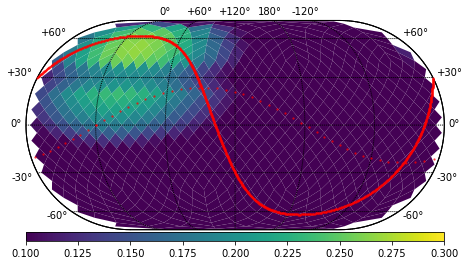

In [95]:
pl.figure(figsize=(7.5,5))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
    m = desiutil.plots.init_sky(ecliptic_color='r')
    _plotdata = desiutil.plots.prepare_data(t['fraction of time observable'],clip_lo=0.1,clip_hi=0.3,save_limits=True)
    desiutil.plots.plot_healpix_map(_plotdata,nest=True,basemap=m)